# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

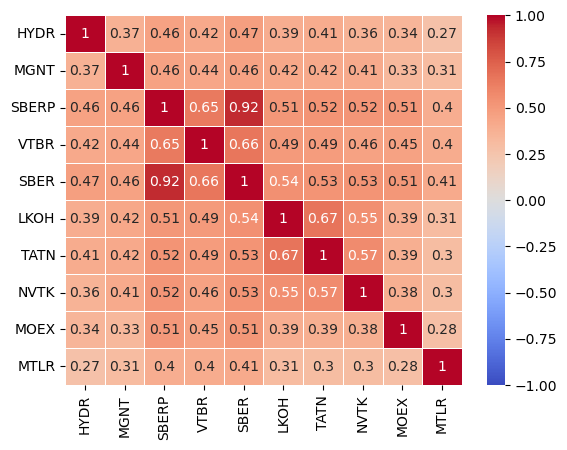

# GANs

In [6]:
import torch
from torch import optim, nn
from tqdm.notebook import tqdm
from IPython.display import clear_output

## Dataset

In [7]:
from dataset import get_pytorch_datataset

WINDOW_SIZE = 50
BATCH_SIZE = 256

dataset, dataloader, N_ASSETS = get_pytorch_datataset(window_size=WINDOW_SIZE, batch_size=BATCH_SIZE)
print(f'Dataset lengths: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
print(f'Sample batch: {next(iter(dataloader)).size()}')

Chosen tickers: ['LKOH', 'SBERP', 'VTBR', 'SBER', 'MOEX', 'HYDR', 'TATN', 'MGNT', 'NVTK', 'MTLR']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2478
Dataset lengths: 2428
Number of assets: 10
Sample batch: torch.Size([256, 10, 50])


## Noise function

In [8]:
def get_noise(batch_size: int, window_size: int, noise_size: int):
    return torch.randn(batch_size, noise_size, window_size)

In [9]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [10]:
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """

    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.relu(out + res)


class Generator(nn.Module):
    """Generator: 3 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    NOISE_WINDOW_SIZE = WINDOW_SIZE
    NOISE_SIZE = N_ASSETS * 3
    HIDDEN_CHANNELS = 10

    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(self.NOISE_SIZE, self.HIDDEN_CHANNELS, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(self.HIDDEN_CHANNELS, self.HIDDEN_CHANNELS, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8]]])
        self.last = nn.Conv1d(10, N_ASSETS, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x


class Discriminator(nn.Module):
    """Discrimnator: 1 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    HIDDEN_CHANNELS = 10

    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(N_ASSETS, self.HIDDEN_CHANNELS, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(self.HIDDEN_CHANNELS, self.HIDDEN_CHANNELS, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8]]])
        self.last = nn.Conv1d(self.HIDDEN_CHANNELS, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(seq_len, 1), nn.Sigmoid())

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return self.to_prob(x).squeeze()


assert Discriminator(seq_len=WINDOW_SIZE)(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(get_noise(BATCH_SIZE, Generator.NOISE_WINDOW_SIZE, Generator.NOISE_SIZE)).size() == next(iter(dataloader)).size()

## Train

In [11]:
loss_fn = nn.BCELoss()


def train_epoch(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader):
    generator_losses = []
    discriminator_losses = []
    for real_samples in dataloader:  # Iterate over batches of real samples
        real_samples = real_samples.to(DEVICE)

        # Generate fake samples from the generator
        z = get_noise(real_samples.shape[0], generator.NOISE_WINDOW_SIZE, generator.NOISE_SIZE).to(DEVICE)  # Sample noise
        with torch.no_grad():
            fake_samples = generator(z)
        real_labels = torch.ones(real_samples.shape[0]).to(DEVICE)
        fake_labels = torch.zeros(real_samples.shape[0]).to(DEVICE)

        # Train the discriminator
        discriminator_optimizer.zero_grad()
        # Compute discriminator loss on real samples
        real_loss = loss_fn(discriminator(real_samples), real_labels)
        # Compute discriminator loss on fake samples
        fake_loss = loss_fn(discriminator(fake_samples), fake_labels)
        # Compute the total discriminator loss
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Train the generator
        generator_optimizer.zero_grad()
        # Generate fake samples and compute generator loss
        fake_samples = generator(z)
        generator_loss = loss_fn(discriminator(fake_samples), real_labels)
        generator_loss.backward()
        generator_optimizer.step()

        discriminator_losses.append(discriminator_loss.item())
        generator_losses.append(generator_loss.item())
    return np.mean(generator_losses), np.mean(discriminator_losses)


@torch.no_grad()
def generate_samples(generator):
    df_returns_fake = pd.DataFrame(generator(get_noise(1, generator.NOISE_WINDOW_SIZE, generator.NOISE_SIZE).to(DEVICE)).squeeze().cpu().T, columns=dataset.assets)
    return df_returns_fake


def plot_gan(generator, epoch):
    df_returns_fake = generate_samples(generator)
    print(f'Fake std: {df_returns_fake.std(axis=0).values}.\nReal std: {df_returns.std(axis=0).values}')
    print(f'Fake correlation: {df_returns_fake.corr().loc["SBER", "SBERP"]}. Real correlation: {df_returns.corr().loc["SBER", "SBERP"]}')
    plt.subplots(1, 2, figsize=(15, 5))
    for i, col in enumerate(['SBER', 'SBERP']):
        plt.subplot(1, 2, i + 1)
        sns.histplot(df_returns[col], stat='density')
        sns.histplot(df_returns_fake[col], stat='density')
        plt.axvline(df_returns[col].min(), linestyle='dashed', color='C0')
        plt.axvline(df_returns[col].max(), linestyle='dashed', color='C0')
        plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
        plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')
        plt.title(f'{col} ({epoch} epoch)')
    plt.show()


def train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, n_epochs):
    generator_losses = []
    discriminator_losses = []

    for epoch in tqdm(range(n_epochs)):
        generator_loss, discriminator_loss = train_epoch(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader)
        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)

        if epoch % 20 == 0:
            clear_output(wait=True)
            plot_gan(generator, epoch)

    clear_output(wait=True)
    plot_gan(generator, epoch)
    plt.plot(generator_losses, label='generator loss')
    plt.plot(discriminator_losses, label='discriminator loss')
    plt.legend()
    plt.show()
    return generator_losses, discriminator_losses

## Experiments

Fake std: [0.00394358 0.03397676 0.01851435 0.01428848 0.01276318 0.01041202
 0.0065459  0.03046557 0.01436691 0.0182472 ].
Real std: [0.01942698 0.02184276 0.02290373 0.02340212 0.01879028 0.01955697
 0.02299302 0.02144388 0.02153786 0.0415686 ]
Fake correlation: -0.9632176065319329. Real correlation: 0.9226111969303874


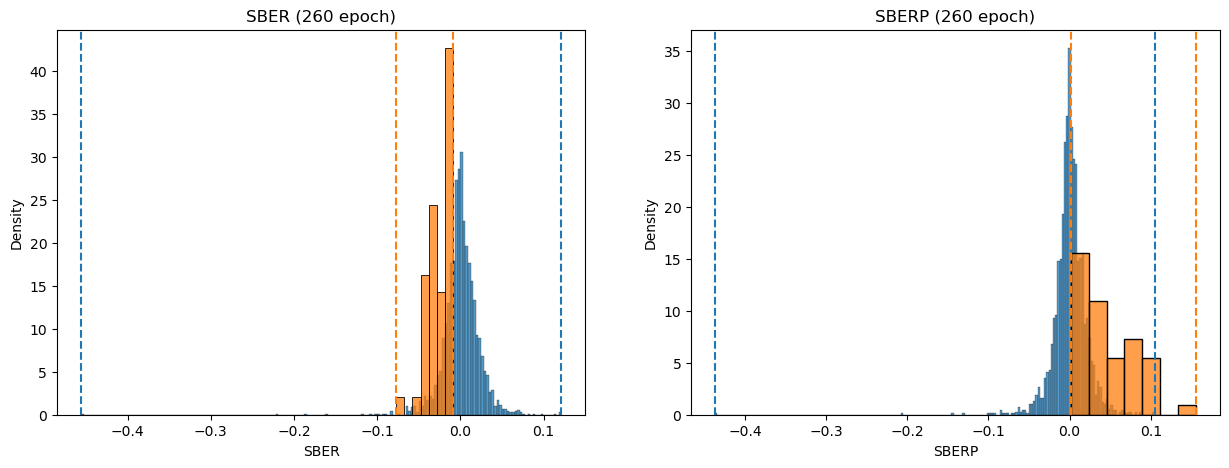

KeyboardInterrupt: 

In [16]:
N_EPOCHS = 1000

discriminator = Discriminator(seq_len=WINDOW_SIZE).to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.001
generator_optimizer = optim.Adam(generator.parameters(), lr=LR)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR)

_ = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, n_epochs=N_EPOCHS)

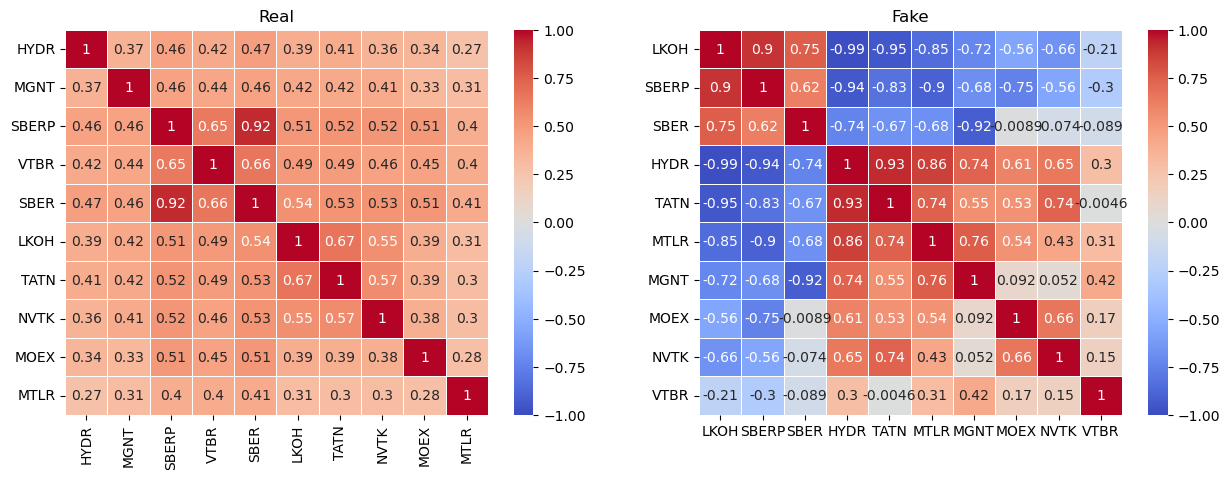

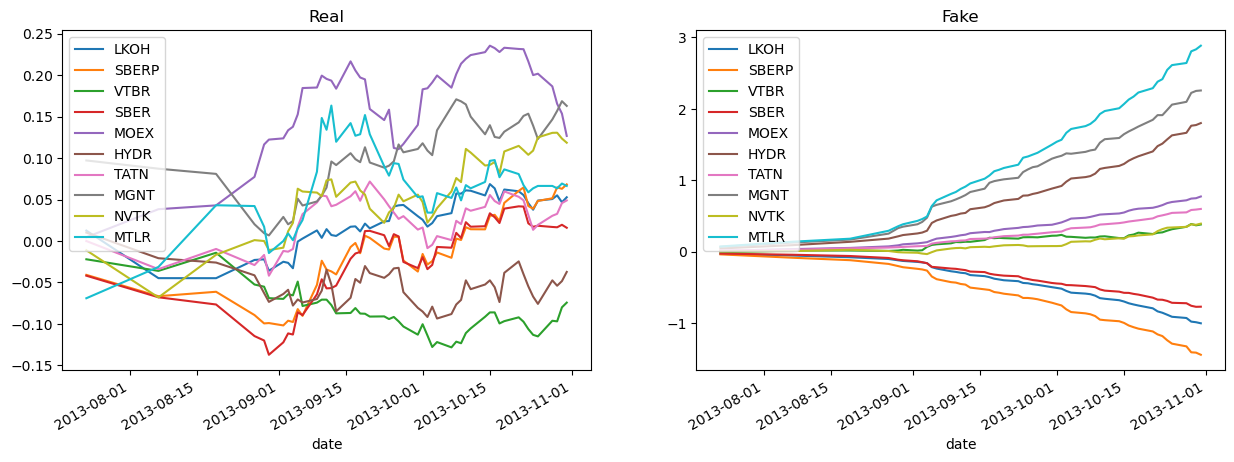

In [21]:
df_returns_fake = pd.DataFrame(generate_samples(generator), columns=dataset.assets)

plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Real')
plot_correlation_matrix(df_returns[dataset.assets].corr())


plt.subplot(1, 2, 2)
plt.title('Fake')
plot_correlation_matrix(df_returns_fake.corr())
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Real')
df_returns.iloc[:WINDOW_SIZE][dataset.assets].cumsum().plot(ax=ax1)

plt.subplot(1, 2, 2)
plt.title('Fake')
df_returns_fake.set_index(df_returns[:WINDOW_SIZE].index).cumsum().plot(ax=ax2)
plt.show()

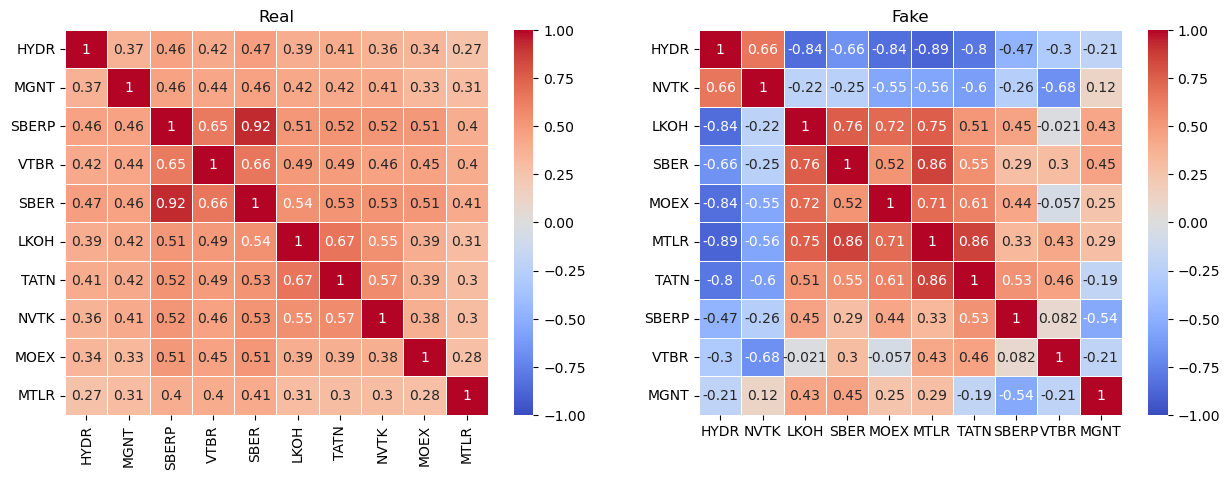

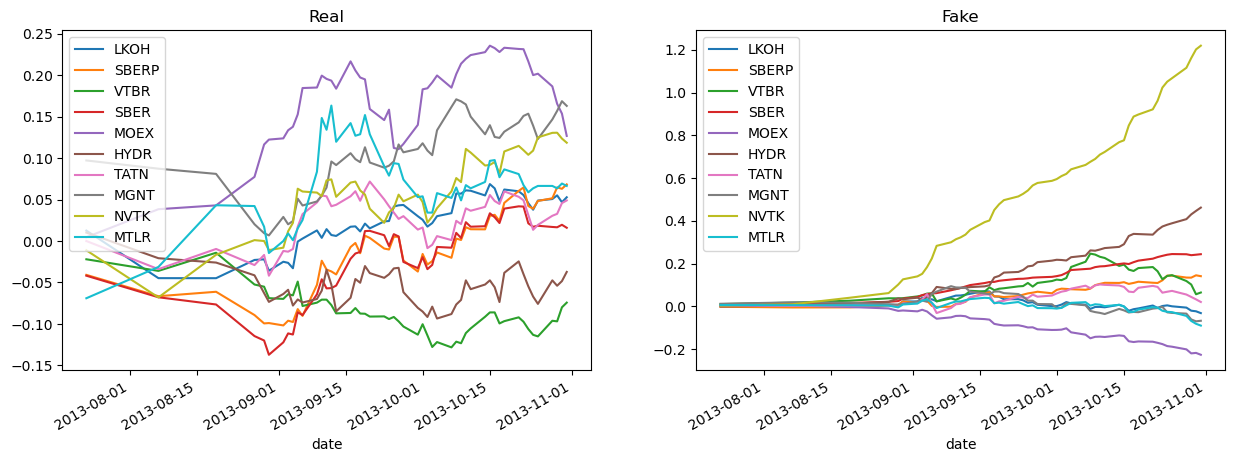

In [15]:
df_returns_fake = pd.DataFrame(generate_samples(generator), columns=dataset.assets)

plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Real')
plot_correlation_matrix(df_returns[dataset.assets].corr())


plt.subplot(1, 2, 2)
plt.title('Fake')
plot_correlation_matrix(df_returns_fake.corr())
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Real')
df_returns.iloc[:WINDOW_SIZE][dataset.assets].cumsum().plot(ax=ax1)

plt.subplot(1, 2, 2)
plt.title('Fake')
df_returns_fake.set_index(df_returns[:WINDOW_SIZE].index).cumsum().plot(ax=ax2)
plt.show()